In [1]:
using Arpack
using LinearAlgebra
using CairoMakie
using LaTeXStrings

In [2]:
function hDirac(m, k)
    kx = k[1]
    ky = k[2]
    ham = zeros(ComplexF64, 2, 2)
    ham[1, 1] = 2 - m - cos(kx) - cos(ky)
    ham[2, 2] = -(2 - m - cos(kx) - cos(ky))
    ham[1, 2] = -1im * sin(ky) + sin(kx)
    ham[2, 1] = 1im * sin(ky) + sin(kx)
    return ham
end

hDirac (generic function with 1 method)

In [61]:
samps = 1000
k_range = range(-pi, pi, samps)
m = 0.01
pd = 100

100

In [62]:
# Get the dipersions for fixed ky
K_temp_vals = Array{Float64}(undef, samps, samps, 2)
K_temp_points = Array{Float64}(undef, samps, samps, 2)
for i in 1:samps
    for j in 1:samps
        kx = k_range[i]
        ky = k_range[j]
        ham = hDirac(m, [kx, ky])
        vals = eigvals(Hermitian(ham))
        K_temp_vals[i, j, :] = real(vals)
        K_temp_points[i, j, :] = [kx, ky]
    end
end

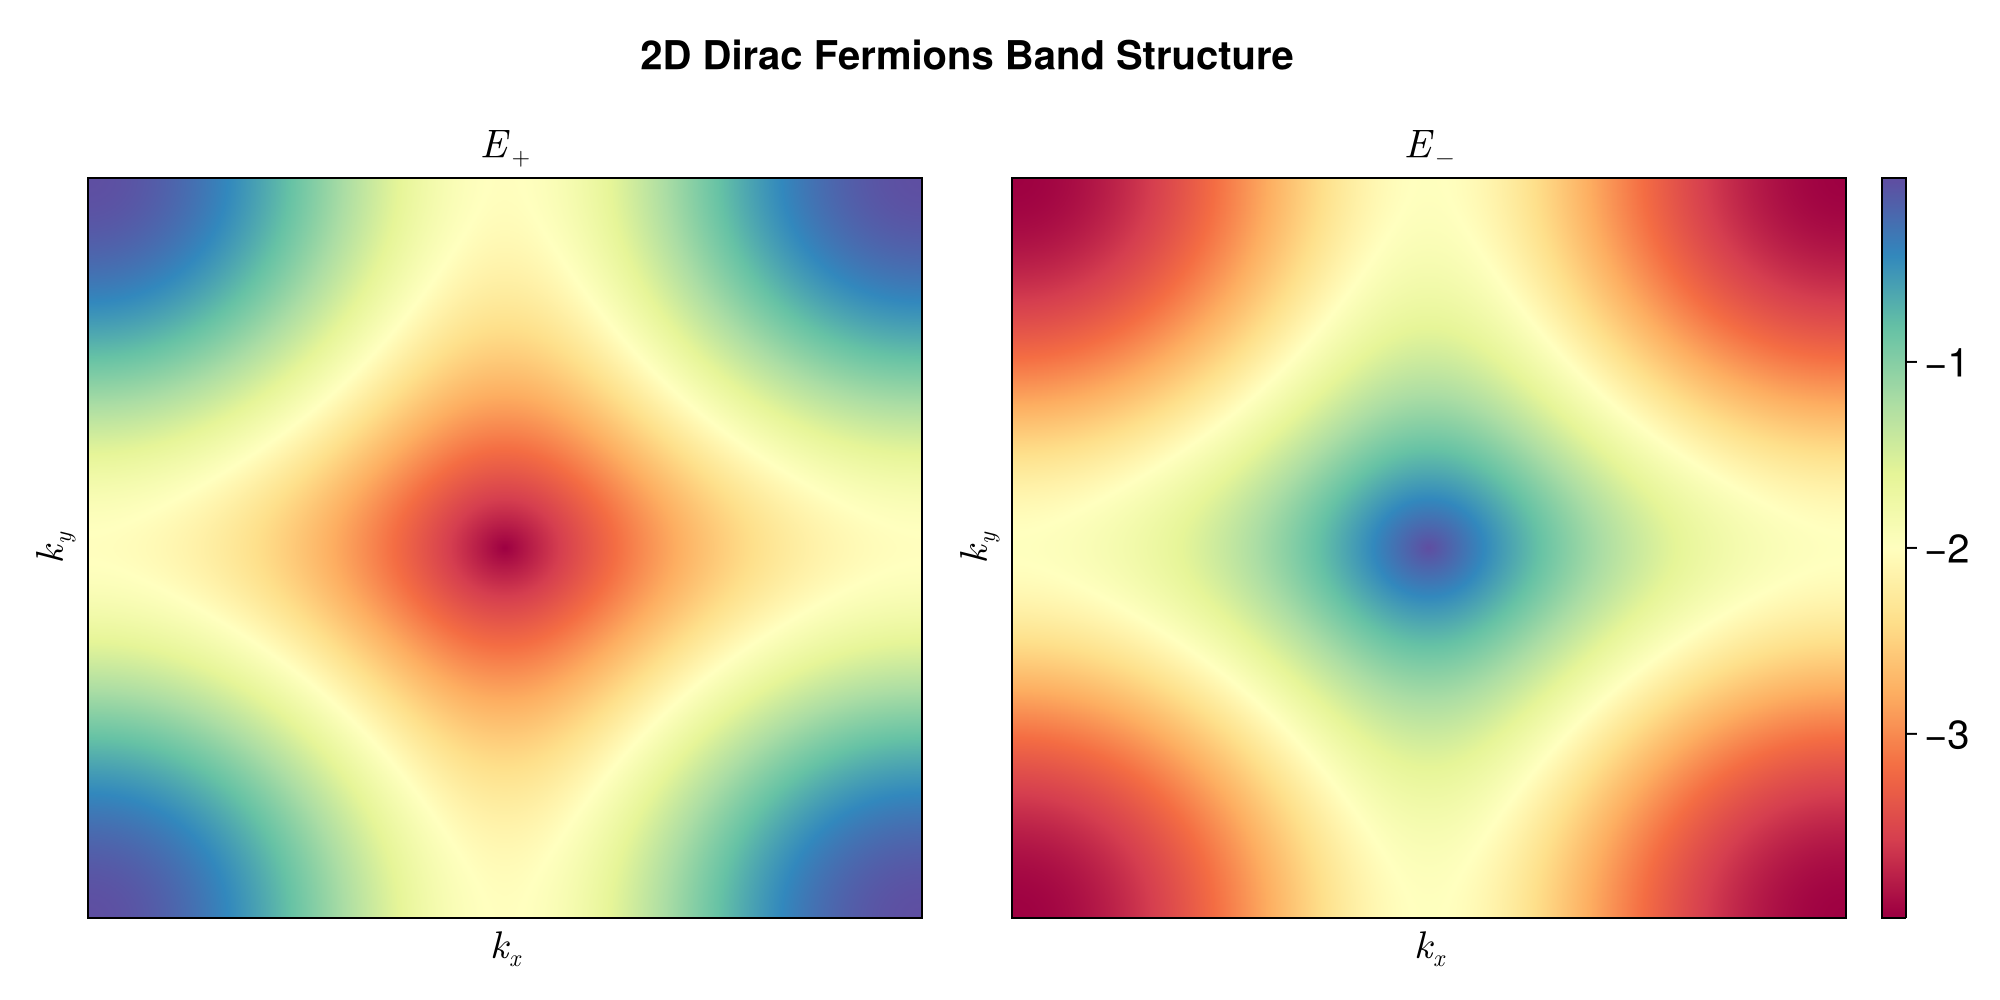

In [63]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)

# create and configure axes
ax_plus = Axis(P[1, 1], title = L"E_+", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_plus, label = false)
ax_minus = Axis(P[1, 2], title = L"E_-", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_minus, label = false)
ax_major = Axis(P[:, :], title = "2D Dirac Fermions Band Structure", titlegap = 50)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

#plot dispersions
heatmap!(ax_plus, k_range, k_range, K_temp_vals[:, :, 2], colormap = :Spectral)
heatmap!(ax_minus, k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)
X, ax, tr = heatmap(k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)

#create and configure the colorbar
cb = Colorbar(P[1, 3], tr)
P

In [64]:
# This generates a line of points in K-space
function gen_list(xlim, n, shift, y)
    x_vals = range(-xlim + shift, shift, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end

gen_list (generic function with 1 method)

In [65]:
# square in k_space centered around the origin
function k_square(limit, n)
    vals = range(-limit/2, limit/2, n)
    grid = Array{Float64}(undef, n, n, 2)
    for i in 1:n
        grid[:, i, :] = gen_list(limit, n, limit/2, vals[i])
    end
    return grid
end

k_square (generic function with 1 method)

In [66]:
uc_k_grid = k_square(2 * pi, pd)

100×100×2 Array{Float64, 3}:
[:, :, 1] =
 -3.14159  -3.14159  -3.14159  -3.14159  …  -3.14159  -3.14159  -3.14159
 -3.07813  -3.07813  -3.07813  -3.07813     -3.07813  -3.07813  -3.07813
 -3.01466  -3.01466  -3.01466  -3.01466     -3.01466  -3.01466  -3.01466
 -2.95119  -2.95119  -2.95119  -2.95119     -2.95119  -2.95119  -2.95119
 -2.88773  -2.88773  -2.88773  -2.88773     -2.88773  -2.88773  -2.88773
 -2.82426  -2.82426  -2.82426  -2.82426  …  -2.82426  -2.82426  -2.82426
 -2.76079  -2.76079  -2.76079  -2.76079     -2.76079  -2.76079  -2.76079
 -2.69733  -2.69733  -2.69733  -2.69733     -2.69733  -2.69733  -2.69733
 -2.63386  -2.63386  -2.63386  -2.63386     -2.63386  -2.63386  -2.63386
 -2.57039  -2.57039  -2.57039  -2.57039     -2.57039  -2.57039  -2.57039
  ⋮                                      ⋱                      
  2.63386   2.63386   2.63386   2.63386      2.63386   2.63386   2.63386
  2.69733   2.69733   2.69733   2.69733      2.69733   2.69733   2.69733
  2.76079   2.7607

In [67]:
# get the eigenvector corresponding to the band-index (l) @ k = (kx, ky)
function eigen_vec_Dirac(kx, ky, m, sign)
    ham = hDirac(m, [kx, ky])
    vecs = eigvecs(Hermitian(ham))
    vals = eigvals(Hermitian(ham))
    if sign > 0
        return vecs[:, 1]
    else
        return vecs[:, 2]
    end
end

eigen_vec_Dirac (generic function with 1 method)

In [68]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta_Dirac(x1, y1, x2, y2, m, sign)
    ev1 = eigen_vec_Dirac(x1, y1, m, sign)
    ev2 = eigen_vec_Dirac(x2, y2, m, sign)
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta_Dirac (generic function with 1 method)

In [69]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux_Dirac(x1, y1, x2, y2, x3, y3, x4, y4, m, sign)
    big_theta = theta_Dirac(x2, y2, x1, y1, m, sign) * theta_Dirac(x3, y3, x2, y2, m, sign) * 
    theta_Dirac(x4, y4, x3, y3, m, sign) * theta_Dirac(x1, y1, x4, y4, m, sign)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux_Dirac (generic function with 1 method)

In [70]:
# Berry curvature over all plaquettes
function berry_curvature_Dirac(points, n, m, sign)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(n - 1)
        for j in 1:(n - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            
            curvature = -flux_Dirac(x1, y1, x2, y2, x3, y3, x4, y4, m, sign)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature_Dirac (generic function with 1 method)

In [71]:
# Berry curvature over all plaquettes
function berry_curvature_2(points, n, m, sign)
    berry_list = Array{Float64}(undef, n^2)
    for i in 1:n^2
        # get flux through plaquette centered at point
        angles = Array{Float64}(undef, 4)
        square = Array{Float64}(undef, length(angles), 2)
        x0 = points[i, 1]
        y0 = points[i, 2]
        spacing = 10^(-1) * pi/n
        for j in 1:length(angles)
            square[j, 1] = x0 + spacing * cos(2 * pi * (j - 1) / length(angles))
            square[j, 2] = y0 + spacing * sin(2 * pi * (j - 1) / length(angles))
        end
        berry_list[i] = -flux_Dirac(square[1, 1], square[1, 2], square[2, 1], square[2, 2], square[3, 1], square[3, 2], square[4, 1], square[4, 2], 
        m, sign)
    end
    return berry_list
end

berry_curvature_2 (generic function with 1 method)

In [72]:
# Get berry curvature for all bands
@time begin
flux_list = Array{Float64}(undef, 2, (pd - 1)^2)
uc_flux_list = Array{Float64}(undef, 2, (pd)^2)
akx = Array{Float64}(undef, 2, (pd)^2)
aky = Array{Float64}(undef, 2, (pd)^2)
new_grid = reshape(uc_k_grid, (pd^2, 2))
for l in 1:2
    # temp_flux, avkx, avky = berry_curvature_Dirac(uc_k_grid, pd, m, 1.5 - l)
    # uc_temp_flux, trash, trash = berry_curvature_Dirac(uc_k_grid, pd, m, 1.5 - l)
    # uc_flux_list[l, :] = uc_temp_flux
    # flux_list[l, :] = temp_flux
    # akx[l, :] = avkx
    # aky[l, :] = avky
    uc_flux_list[l, :] = berry_curvature_2(new_grid, pd, m, 1.5 - l)
    akx[l, :] = new_grid[:, 1]
    aky[l, :] = new_grid[:, 2]
    end
end

In [73]:
# Compute the Chern numbers of each band
chern_numbers = Array{Float64}(undef, 2)
for l in 1:2
    chern_numbers[l] = sum(uc_flux_list[l, :]) / (2 * pi)
end
@show chern_numbers

2-element Vector{Float64}:
 -0.003409133926618815
  0.0034091339266191095

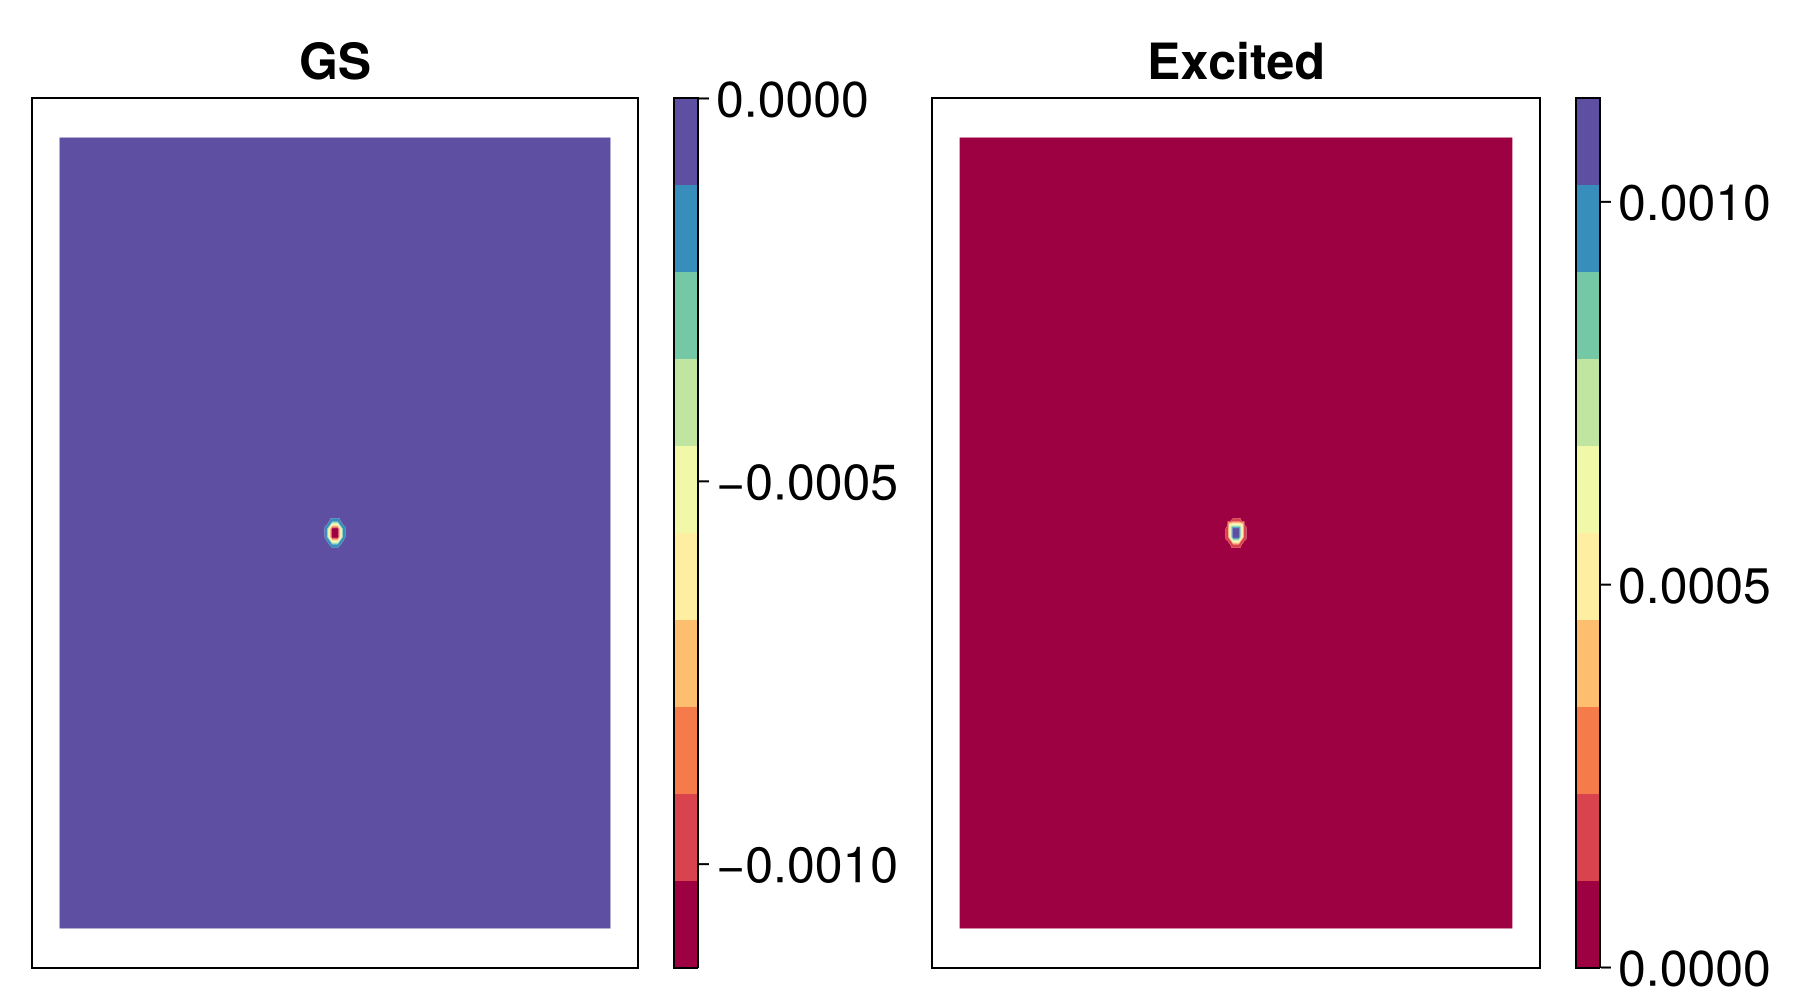

In [74]:
@time begin
fig = Figure(size=(900, 500), fontsize=25)
    
ax = Axis(fig[1, 1], title = "GS")
hidedecorations!(ax)
tricontourf!(ax, akx[1, :], aky[1, :], uc_flux_list[1, :], colormap = :Spectral)
X, ax1, tr1 = tricontourf(akx[1, :], aky[1, :], uc_flux_list[1, :], colormap = :Spectral)
cb1 = Colorbar(fig[1, 2], tr1)

ax = Axis(fig[1, 3], title = "Excited")
hidedecorations!(ax)
tricontourf!(ax, akx[2, :], aky[2, :], uc_flux_list[2, :], colormap = :Spectral)
X, ax2, tr2 = tricontourf(akx[2, :], aky[2 ,:], uc_flux_list[2, :], colormap = :Spectral)
cb1 = Colorbar(fig[1, 4], tr2)


fig
end